# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction and Problem Formulation

Consider a slightly more advanced formulation of rocket landing where the rocket state $x(t)$ is represented by its position and orientation $p(t) = (x(t), y(t), \theta (t))$ and its associated velocity $v(t) = (\dot{x}(t), \dot{y}(t), \dot{\theta}(t))$, i.e., $X(t) = [p(t), v(t)]^T = [x(t), y(t), \theta (t), \dot{x}(t), \dot{y}(t), \dot{\theta}(t)]^T$, where $t$ specifies time. Note that the angle $\theta$ is measured from the y-axis. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
p(t+1) = p(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(X(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

We define a loss as a function of the state as $l(X(t))$. Here, the loss function will be a weighted sum of squared errors between the rocket's state and the desired state of $X_{d}(T) = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]^T$. The total loss function can then be expressed as
$$
l(X(t),a(t)) = \sqrt{w_x (x(t) - x_d(T))^2 + w_y (y(t) - y_d(T))^2 + w_{\theta} (\theta(t) - \theta_d(T))^2 + w_{\dot{x}} (\dot{x}(t) - \dot{x}_d(T))^2 + w_{\dot{y}} (\dot{y}(t) - \dot{y}_d(T))^2 + w_{\dot{\theta}} (\dot{\theta}(t) - \dot{\theta}_d(T))}
$$

The optimization problem is now formulated as:

$$
\begin{aligned}
\min_{\theta} \quad & ||l(X(T), a(T))||_2^2 \\
\quad & p(t+1) = p(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(X(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

Furthermore, note that this controller $f_{\theta}(\cdot)$ would be trained for a specific starting configuration. Ideally the controller would work for a variety of initial configurations and perform reasonably well.

In summary, the changes to the given problem formulation are as follows
* State Space was moved to a 6-dimensional reprensetation to capture planar movement and orientation of the rocket
* The input action of the amount of thrust is unchanged, but the thrust operates in the direction of the rocket's orientation.
* The loss function is updated to reflect the more complicated problem of trying to land a rocket in a single spot in the upright position. The weights were added to the loss function to tune relative importance between the various terms. For example, it may be more desired to land on the ground with a net velocity of near zero (higher weights on velocity error) rather than crash the rocket into the correct spot (higher weights on position error).

Similarlly, the changes to the method compared to the same code are aas follows
* The structure neural network was only slightly changed. Iterative testing showed that the network performed better when a more simple structure was chosen. Only one hidden layer was added to the original structure and the various dimensions were changed slightly to suit the problem. 
* The neural network was initally trained over one initial condition. The resultant network was tested on a larget set of starting configurations to evaluate the performance of the controller for a more general case. Then the same network is further trained over a batch of initial conditions and the same check is performed to see how well the trained controller performs when trained over a distribution of initial conditions. 


---

## 2. Code

Below is the implimentation of the optimization problem described in Section 1. The structure is largely based on the sample code but a number of changes have been made to accomidate the change in problem formulation.

In [1236]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import random

logger = logging.getLogger(__name__)

In [1237]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [1238]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()
        self.noise_params_dict = {'position_std': 0.5, 'angular_std': 0.1, 'position_vel_std': 0.2, 'angular_vel_std': 0.01}
    
    @staticmethod
    def forward(state, action): # works now?
        noise_params_dict = {'position_std': 1.0, 'angular_std': 1.0, 'position_vel_std': 1.0, 'angular_vel_std': 1.0}
        """
        action: [thrust_mag; trust_angle]
        state: [x, y, angle, dx, dy, dangle]
        """
        thrust_distance = 0.1
        state_noise_mult = 0.000
        angle_one_sided_bound = 10.0
        angle_scale = 2.0 * (angle_one_sided_bound / 180.0) * 3.14
        angle_shift = angle_scale / 2.0
        state_noise = state_noise_mult * t.tensor([np.random.normal(0.0, noise_params_dict['position_std']),
            np.random.normal(0.0, noise_params_dict['position_std']),
            np.random.normal(0.0, noise_params_dict['angular_std']),
            np.random.normal(0.0, noise_params_dict['position_vel_std']),
            np.random.normal(0.0, noise_params_dict['position_vel_std']),
            np.random.normal(0.0, noise_params_dict['angular_vel_std'])])
        

        # Apply gravit
        delta_state_gravity = t.tensor([0., 0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME, 0.])

        # added: various thrust terms for higher dimentional approach
        r_thrust = thrust_distance * t.tensor([t.sin(state[2]), -t.cos(state[2]), 0.0])
        # Thrust
        thrust_angle = t.tensor([0.0]) # no longer used.
        dangle_vel_vec = t.cross(r_thrust, t.tensor([t.sin(thrust_angle), t.cos(thrust_angle), 0.0]))


        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 
            t.sin(state[2] + thrust_angle), 
            t.cos(state[2] + thrust_angle), 
            0.0 * dangle_vel_vec[2]]) * action

        # drag
        drag_coeff = 0.2
        delta_state_drag = -drag_coeff * FRAME_TIME * t.tensor([0., 0., 0., state[3], state[4], state[5]])

        # Update velocity
        state = state + delta_state + delta_state_gravity + state_noise + delta_state_drag
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., 0., 0., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0., FRAME_TIME, 0.],
                            [0., 0., 1., 0., 0., FRAME_TIME],
                            [0., 0., 0., 1.0, 0., 0.0],
                            [0., 0., 0., 0., 1.0, 0.0],
                            [0., 0., 0., 0., 0.0, 1.0]])

        state = t.matmul(step_mat, state)

        return state

    @staticmethod
    def direction_from_angle(angle):
        return t.tensor([t.sin(angle), t.cos(angle), 0])

In [1239]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),

            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [1240]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()

        # added: noise params
        self.initial_state_noise = {'position_mag': 0.5, 'angular_mag': 0.1, 'position_vel_mag': 0.1, 'angular_vel_mag': 0.01, 'mult_lb': -1.0, 'mult_ub': 1.0}
        #self.initial_state_noise = {'position_mag': 0.3, 'angular_mag': 0.1, 'mult_lb': -1.0, 'mult_ub': 1.0}
        self.flag_random_initial_states = False

        self.state = self.initialize_state(self.initial_state_noise)
        self.state_initial = self.state
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(initial_state_noise_dict):
        state = [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]  # TODO: need batch of initial states
        x_scale = 1.0
        y_scale = 0.0
        #state_noise = [initial_state_noise_dict['position_mag'], initial_state_noise_dict['position_mag'], initial_state_noise_dict['angular_mag'], 0.0, 0.0, 0.0]
        state_noise = [x_scale * initial_state_noise_dict['position_mag'], 0.0, initial_state_noise_dict['angular_mag'], 
            initial_state_noise_dict['position_vel_mag'], initial_state_noise_dict['position_vel_mag'], initial_state_noise_dict['angular_vel_mag']]
        random_state_mult = t.tensor(np.random.uniform(initial_state_noise_dict['mult_lb'], initial_state_noise_dict['mult_ub'], size=len(state)), requires_grad=False).float()
        #print("Initial state mutiplier tensor: " + str(random_state_mult))
        #random.uniform(initial_state_noise_dict['mult_lb'], initial_state_noise_dict['mult_ub'])
        state = t.tensor(state, requires_grad=False).float() + \
            random_state_mult * t.tensor(state_noise, requires_grad=False).float()
        #("Initial state tensor: " + str(state))
        state.requires_grad_()
        return state

    def error(self, state):
        vel_weight = 4.0
        x_weight = 1.0
        y_weight = 1.0
        angle_weight = 1.0
        return  x_weight * state[0]**2 + y_weight * state[1]**2 + angle_weight * state[2]**2 + vel_weight * (state[3]**2 + state[4]**2) + (angle_weight * vel_weight) * (state[5]**2)
        #return state[0]**2 + state[1]**2 + (state[3]**2 + state[4]**2)

In [1241]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done
    
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        #self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # changed :: lr was 0.01
        self.optimizer = optim.Adam(self.parameters, lr=0.01)
        #self.optimizer = optim.SGD(self.parameters, lr=0.01, momentum=0.2, dampening=0.0, nesterov=True)
        #self.optimizer = optim.Rprop(self.parameters, lr=0.01)

        self.flag_decay_lr = True
        self.scheduler = t.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.99) # added
        self.verbose = True

        # added
        self.diagnostics_dict = {'epoch' : [], 'loss' : [], 'loss_percent_change': [], 'state_trajectory' : [], 'action_trajectory' : []}

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            if self.verbose:
                print('[epoch: %d] loss: %.3f' % (epoch + 1, loss))
            #print("Action Trajectory" + str(self.simulation.action_trajectory))
            # added
            info_diagnostics = {'epoch' : epoch, 'loss' : loss}
            info_simulation = {'action_trajectory' : self.simulation.action_trajectory, 'state_trajectory' : self.simulation.state_trajectory}
            self.recordDiagnostics(info_diagnostics, info_simulation)

            if self.simulation.flag_random_initial_states:
                self.simulation.state = self.simulation.initialize_state(self.simulation.initial_state_noise)
                
            if self.flag_decay_lr:
                self.scheduler.step()
                
        self.postProcessDiagnostics()
        if self.verbose:
            self.visualize_summary()
            self.visualize_final_trajectory()
            self.visualize_convergence()
        

    def recordDiagnostics(self, info, info_sim):
        self.diagnostics_dict['epoch'].append(info['epoch'])
        self.diagnostics_dict['loss'].append(info['loss'].item())
        self.diagnostics_dict['state_trajectory'].append(info_sim['state_trajectory'])
        self.diagnostics_dict['action_trajectory'].append(info_sim['action_trajectory'])

    def postProcessDiagnostics(self):
        loss_percent_change = [(self.diagnostics_dict['loss'][i+1] - self.diagnostics_dict['loss'][i]) / self.diagnostics_dict['loss'][i] for i in range(len(self.diagnostics_dict['epoch']) - 1)]
        self.diagnostics_dict['loss_percent_change'] = loss_percent_change

    def visualize_summary(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        theta = data[:, 2]
        dx = data[:, 3]
        dy = data[:, 4]
        dtheta = data[:, 5]
        #error = [self.simulation.error([x[i], y[i], theta[i], dx[i], dy[i], dtheta[i]]) for i in range(len(x))]


        fig, ax = plt.subplots()
        plt.figure(1)
        p1 = ax.plot(self.diagnostics_dict['epoch'], self.diagnostics_dict['loss'])
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.set_title('Total Loss Per Epoch')
        plt.show()

        fig, ax = plt.subplots()
        plt.figure(2)
        delta_epoch = self.diagnostics_dict['epoch'][1:]
        p2 = ax.plot(delta_epoch, self.diagnostics_dict['loss_percent_change'])
        ax.set_ylabel('Percent Change in Loss')
        ax.set_xlabel('Epoch')
        ax.set_title('Percent Change in Loss Per Epoch')
        plt.show()

    def visualize_final_trajectory(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        theta = data[:, 2]
        dx = data[:, 3]
        dy = data[:, 4]
        dtheta = data[:, 5]

        fig, ax = plt.subplots()
        
        ax.scatter(x, y)
        ax.set_ylabel('Y Position')
        ax.set_xlabel('X Position')
        ax.set_title('Final Trajectory')
        ax.set_xlim([-0.7, 0.7])
        ax.set_ylim([-0.05, 1.2])
        dir_dict = self.direction_from_angle_list(theta)
        ax.quiver(x, y, dir_dict['u'], dir_dict['v'])
        plt.show()
        #error = [self.simulation.error([x[i], y[i], theta[i], dx[i], dy[i], dtheta[i]]) for i in range(len(x))]

    def visualize_convergence(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        theta = data[:, 2]
        dx = data[:, 3]
        dy = data[:, 4]
        dtheta = data[:, 5]

        fig, ax = plt.subplots()
        plt.figure(1)
        pos = np.array([x, y])
        pos_mag = np.linalg.norm(pos, axis=0)
        time_index = [i for i in range(len(pos_mag))]
        ax.scatter(time_index, pos_mag)
        ax.set_ylabel('Position Error')
        ax.set_xlabel('Time Index')
        ax.set_title('Position Error Trajectory')
        plt.show()
        #error = [self.simulation.error([x[i], y[i], theta[i], dx[i], dy[i], dtheta[i]]) for i in range(len(x))]

        fig, ax = plt.subplots()
        plt.figure(2)
        time_index = [i for i in range(len(theta))]
        ax.scatter(time_index, np.abs(theta))
        ax.set_ylabel('Angle Error')
        ax.set_xlabel('Time Index')
        ax.set_title('Angle Error Trajectory')
        #ax.set_xlim([-0.5, 0.5])
        #ax.set_ylim([-0.1, 1.1])
        plt.show()
        #error = [self.simulation.error([x[i], y[i], theta[i], dx[i], dy[i], dtheta[i]]) for i in range(len(x))]

        fig, ax = plt.subplots()
        plt.figure(3)
        pos_vel = np.array([dx, dy])
        pos_vel_mag = np.linalg.norm(pos_vel, axis=0)
        time_index = [i for i in range(len(pos_vel_mag))]
        ax.scatter(time_index, pos_vel_mag)
        ax.set_ylabel('Positional Velocity Error')
        ax.set_xlabel('Time Index')
        ax.set_title('Positional Velocity Error Trajectory')
        #ax.set_xlim([-0.5, 0.5])
        #ax.set_ylim([-0.1, 1.1])
        plt.show()

    def direction_from_angle_list(self, angle_list):
        dir_u = []
        dir_v = []
        for angle in angle_list:
            dir_u.append(np.sin(angle)) # same if angle is measured from y axis
            dir_v.append(np.cos(angle))
        return {'u': dir_u, 'v': dir_v} 

        

## 3. Results and Analysis

Here the problem presented in Section 1. is solved using the above code. As explained, the controller is optimized for a single initial condition case initially and the ability of the controller to generalize to different initial conditions is evaluated. Following this, the initial controller is further trained on a batch of initial conditions to evaluate how well the controller can generalize if it is trained on a distribution of initial conditions.

[epoch: 1] loss: 0.189
[epoch: 2] loss: 0.141
[epoch: 3] loss: 0.108
[epoch: 4] loss: 0.090
[epoch: 5] loss: 0.087
[epoch: 6] loss: 0.096
[epoch: 7] loss: 0.109
[epoch: 8] loss: 0.119
[epoch: 9] loss: 0.122
[epoch: 10] loss: 0.119
[epoch: 11] loss: 0.113
[epoch: 12] loss: 0.105
[epoch: 13] loss: 0.097
[epoch: 14] loss: 0.092
[epoch: 15] loss: 0.088
[epoch: 16] loss: 0.086
[epoch: 17] loss: 0.085
[epoch: 18] loss: 0.085
[epoch: 19] loss: 0.086
[epoch: 20] loss: 0.086
[epoch: 21] loss: 0.087
[epoch: 22] loss: 0.087
[epoch: 23] loss: 0.086
[epoch: 24] loss: 0.086
[epoch: 25] loss: 0.085
[epoch: 26] loss: 0.084
[epoch: 27] loss: 0.083
[epoch: 28] loss: 0.083
[epoch: 29] loss: 0.082
[epoch: 30] loss: 0.082
[epoch: 31] loss: 0.083
[epoch: 32] loss: 0.083
[epoch: 33] loss: 0.083
[epoch: 34] loss: 0.084
[epoch: 35] loss: 0.084
[epoch: 36] loss: 0.084
[epoch: 37] loss: 0.083
[epoch: 38] loss: 0.083
[epoch: 39] loss: 0.082
[epoch: 40] loss: 0.081
[epoch: 41] loss: 0.080
[epoch: 42] loss: 0.079
[

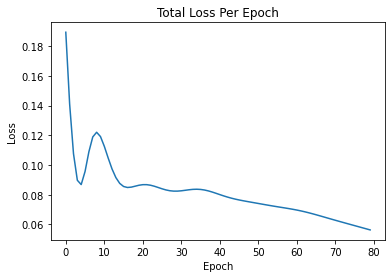

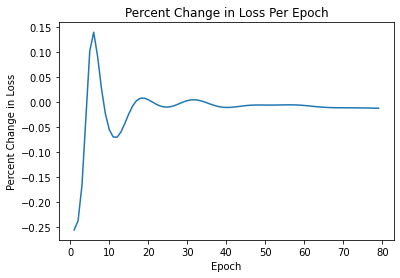

<Figure size 432x288 with 0 Axes>

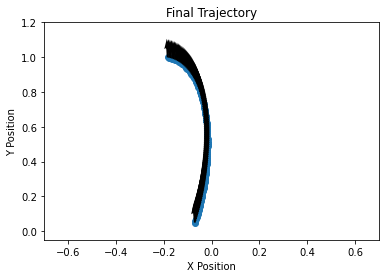

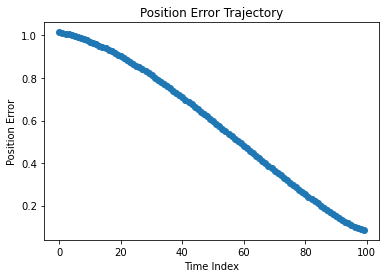

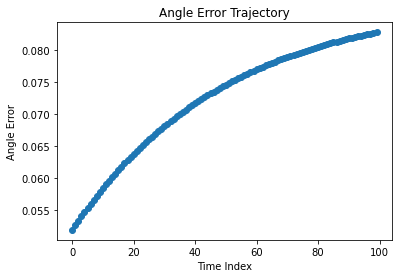

<Figure size 432x288 with 0 Axes>

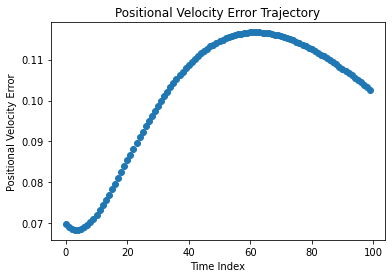

<Figure size 432x288 with 0 Axes>

In [1242]:
# Now it's time to run the code!

T = 100  # number of time steps # changed :: T was 100
epoch_num = 80 # changed :: epoch_num was 40
dim_input = 6  # state space dimensions
dim_hidden = 8  # latent dimensions
dim_output = 1  # action space dimensions

training_state_number = 20
training_loss_list = []

epoch_num_batch = 20

validation_state_number = 500
validation_loss_list = []

bin_num = math.ceil(validation_state_number/5)

d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(epoch_num)  # solve the optimization problem

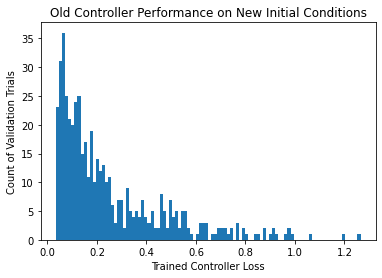

In [1243]:
## Check how controller works for other initial states

c_trained = o.simulation.controller # trained controller from above
for i in range(validation_state_number):
    s_new = Simulation(c_trained, d, T)  # define simulation
    validation_loss_list.append(s_new.forward(s_new.state_initial).item())

fig, ax = plt.subplots()
plt.figure(1)
#p2 = ax.bar([i for i in range(validation_state_number)], validation_loss_list)
p2 = ax.hist(validation_loss_list, bins=bin_num)
ax.set_ylabel('Count of Validation Trials')
ax.set_xlabel('Trained Controller Loss')
ax.set_title('Old Controller Performance on New Initial Conditions')
plt.show()

## Results of Single Initial Condition Case

The trained controller performs well for the trained case, reaching near to the point $(x, y) = (0, 0)$ in the desired time frame as well as reducing net velocity near the end of the trial. 

The "Total Loss Per Epoch" graph shows the expected trend of the loss decreasing as the controller is optimized, but there a few oscillations where the model will perform worse than before for a few epochs. This was found to be mostly dependent on hyperparameters, structure of network, and choice of optimizer. However, the "Percent Change in Loss Per Epoch" graph does show the expected convergence to some (possibly local) minimum as desired. 

The trained controller was then tested on a batch of 500 random initial states and the loss for each of those is shown in the histogram titled "Old Controller Performance on New Initial Conditions." For most sets of initial condition, the controller performs reasonably well but could be improved considerably. 

In [1246]:
## Train controller on sequences of states

c_trained = o.simulation.controller # trained controller from above
for i in range(training_state_number):
    s_new = Simulation(c_trained, d, T)  # define simulation
    o = Optimize(s_new)  # define optimizer
    o.verbose = False
    o.train(epoch_num_batch)  # solve the optimization problem
    training_loss_list.append((s_new.forward(s_new.state_initial).item()))
    c_trained = o.simulation.controller

#fig, ax = plt.subplots()
#plt.figure(1)
#p2 = ax.bar([i for i in range(validation_state_number)], validation_loss_list)
#ax.set_ylabel('Trained Controller Loss')
#ax.set_xlabel('New Initial State Index')
#ax.set_title('Controller Performance on New Initial Conditions')
#plt.show()

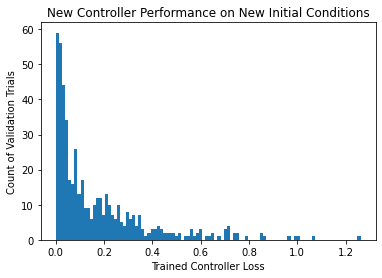

In [1245]:
## Check how controller works for other initial states after training on random states
validation_loss_list = []

c_trained = o.simulation.controller # trained controller from above
for i in range(validation_state_number):
    s_new = Simulation(c_trained, d, T)  # define simulation
    validation_loss_list.append(s_new.forward(s_new.state_initial).item())

fig, ax = plt.subplots()
plt.figure(1)
#p2 = ax.bar([i for i in range(validation_state_number)], validation_loss_list)
p2 = ax.hist(validation_loss_list, bins=bin_num)
ax.set_ylabel('Count of Validation Trials')
ax.set_xlabel('Trained Controller Loss')
ax.set_title('New Controller Performance on New Initial Conditions')
plt.show()

## Results of Further Training on New Initial Conditions

The above controller was further trained on 20 new initial conditions for 20 epochs each and then re-evaluated on a new set of 500 validation conditions, seen in the plot "New Controller Performance on New Initial Conditions." The distribution of the losses is much closer to zero for this case and has a much tigher distribution. This suggests the controller trained on more initial conditions performs far better than a single case for the given loss function. The rates of convergence for each further training are not shown due to length (changing "o.verbose = False" to "o.verbose = True" and rerunning the code will plot all of it if the reader would want to see all of it), but the change in loss for each epoch is often much slower for these new cases, however the change in loss does not quickly converge. It is a slow but steady improvement rather than a sudden improvement that is usually seen when first training a freshly initialized network.